In [1]:
import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import optax
import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import matplotlib.pyplot as plt
import seaborn as sns

from abi_jax import ADVI, MCMC
from abi_jax.utils import train_fn

import pymc as pm
import numpy as np
import arviz as az

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data

In [2]:
tosses = jnp.array([0, 1, 1, 1, 1, 0])

## Model

In [3]:
def log_likelihood_fn(latent_sample, outputs, inputs, **kwargs):
    probs = latent_sample['probability_of_heads']
    return tfd.Bernoulli(probs=probs).log_prob(outputs).sum()

def get_model1():
    a = 1.0
    b = 2.0
    prior = {'probability_of_heads': tfd.Beta(a, b)}
    bijector = {'probability_of_heads': tfb.Sigmoid()}
    return a, b, prior, bijector

a, b, prior, bijector = get_model1()

## True posterior

In [4]:
n_heads = tosses.sum()
n_tails = len(tosses) - n_heads

print(a+n_heads, b+n_tails)
true_posterior = tfd.Beta(a+n_heads, b+n_tails)

5.0 4.0


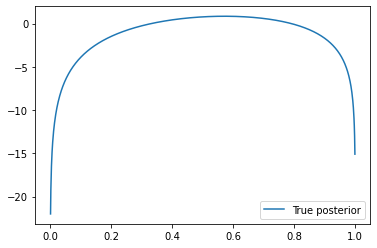

In [5]:
support = {'probability_of_heads': jnp.linspace(0, 1, 1000)}
# true_posterior.log_prob(0.1)
plt.plot(support['probability_of_heads'], true_posterior.log_prob(support['probability_of_heads']), label='True posterior')
plt.legend();

## MCMC

In [6]:
mcmc = MCMC(prior, bijector, log_likelihood_fn)
kernel = mcmc.get_nuts_kernel(outputs=tosses, inputs=None, step_size=1e-3)

seed = jax.random.PRNGKey(9)
init_params = mcmc.init(seed)
seed = jax.random.PRNGKey(10)
samples, _ = mcmc.sample(seed=seed, init_params_pytree=init_params, kernel=kernel, n_burnin=500, n_samples=5000)

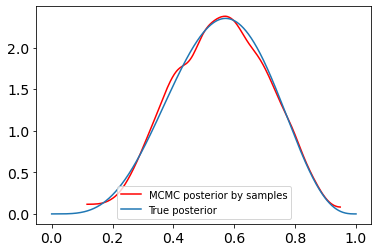

In [7]:
az.plot_dist(samples['probability_of_heads'], label="MCMC posterior by samples", color='red')
plt.plot(support['probability_of_heads'], true_posterior.prob(support['probability_of_heads']), label='True posterior')
# plt.plot(support['probability_of_heads'], pymc_posterior.prob(support['probability_of_heads']), label='ADVI posterior')
plt.legend();

## ADVI

In [8]:
advi = ADVI(prior, bijector, log_likelihood_fn, vi_type='mean_field')

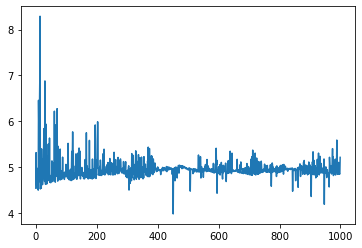

In [9]:
seed = jax.random.PRNGKey(0)
optimizer = optax.adam(learning_rate=0.01)
params = advi.init(seed=seed)
seed = jax.random.PRNGKey(1)

loss_fn = jax.tree_util.Partial(advi.loss_fn, outputs=tosses, inputs=None, full_data_size=len(tosses))
result = train_fn(loss_fn, params, optimizer, n_epochs=1000, seed=seed, return_args=['losses'])
plt.plot(result['losses']);

In [10]:
advi_posterior = advi.apply(result['params'])

{'probability_of_heads': <tfp.bijectors.Sigmoid 'sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>}


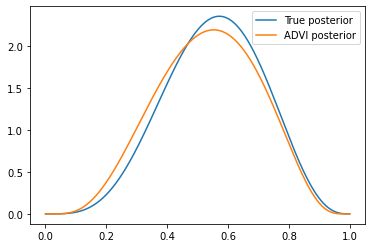

In [11]:
plt.plot(support['probability_of_heads'], true_posterior.prob(support['probability_of_heads']), label='True posterior')
plt.plot(support['probability_of_heads'], advi_posterior.prob(support, sample_shape=(len(support), )), label='ADVI posterior')
plt.legend();

## ADVI with PyMC

In [12]:
with pm.Model() as coin_flipping:
    p = pm.Beta('probability_of_heads', alpha=a, beta=b)
    y = pm.Bernoulli('obs', p=p, observed=tosses)
    pymc_advi = pm.ADVI()
    trace = pymc_advi.fit(n=5000)

Finished [100%]: Average Loss = 4.9947
INFO:pymc.variational.inference:Finished [100%]: Average Loss = 4.9947


In [13]:
samples = trace.sample(draws=5000)['posterior']['probability_of_heads'].values

In [14]:
mu = trace.params[0].eval().astype(np.float32)
sigma = trace.params[1].eval().astype(np.float32)
pymc_posterior = tfd.TransformedDistribution(tfd.Normal(mu, jax.nn.softplus(sigma)), tfb.Sigmoid())

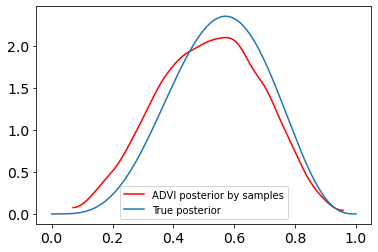

In [15]:
az.plot_dist(samples, label="ADVI posterior by samples", color='red')
plt.plot(support['probability_of_heads'], true_posterior.prob(support['probability_of_heads']), label='True posterior')
# plt.plot(support['probability_of_heads'], pymc_posterior.prob(support['probability_of_heads']), label='ADVI posterior')
plt.legend();

## ADVI with numpyro

In [16]:
from jax import random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import Predictive, SVI, Trace_ELBO

def model(data):
    f = numpyro.sample("latent_fairness", dist.Beta(a, b))
    with numpyro.plate("N", data.shape[0]):
        numpyro.sample("obs", dist.Bernoulli(f), obs=data)

def guide(data):
    alpha_q = numpyro.param("alpha_q", 10.0, constraint=constraints.positive)
    beta_q = numpyro.param("beta_q", 5.0,
                           constraint=constraints.positive)
    numpyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

data = tosses
optimizer = numpyro.optim.Adam(step_size=0.005)
advi_numpyro = SVI(model, guide, optimizer, loss=Trace_ELBO())
advi_numpyro_result = advi_numpyro.run(random.PRNGKey(0), 2000, data)
params = advi_numpyro_result.params
inferred_mean = params["alpha_q"] / (params["alpha_q"] + params["beta_q"])
# get posterior samples
predictive = Predictive(guide, params=params, num_samples=1000)
samples = predictive(random.PRNGKey(1), data)
print(params)

100%|██████████| 2000/2000 [00:01<00:00, 1105.29it/s, init loss: 5.7461, avg. loss [1901-2000]: 4.9520]


{'alpha_q': DeviceArray(5.2036533, dtype=float32), 'beta_q': DeviceArray(4.2812877, dtype=float32)}


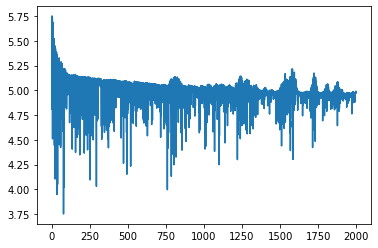

In [17]:
plt.plot(advi_numpyro_result.losses);

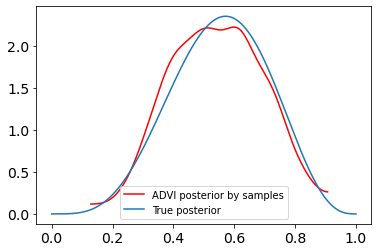

In [18]:
az.plot_dist(samples['latent_fairness'], label="ADVI posterior by samples", color='red')
plt.plot(support['probability_of_heads'], true_posterior.prob(support['probability_of_heads']), label='True posterior')
# plt.plot(support['probability_of_heads'], pymc_posterior.prob(support['probability_of_heads']), label='ADVI posterior')
plt.legend();